<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Bag of Words

### Objetivo
El objetivo es utilizar las críticas de películas para que el sistema determine si la evaluación es positiva o negativa (sentiment analysis como clasificador binario de texto)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

curl: (3) URL using bad/illegal format or missing URL
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23883  100 23883    0     0  32948      0 --:--:-- --:--:-- --:--:-- 33124


In [21]:
from torch_helpers import binary_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = binary_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = binary_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset críticas de películas de IMDB puntuadas deforma positiva o negativa.\
Referencia del dataset: [LINK](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [7]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('imdb_dataset.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1fXW-u9NVbH1yhwU1AHzPVtgGyV1c8N3g'
    output = 'imdb_dataset.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1fXW-u9NVbH1yhwU1AHzPVtgGyV1c8N3g
To: d:\Users\juanp_schamun\Documents\GitRepositories\CEIA\NLP\procesamiento_lenguaje_natural\clase_5\jupyter_notebooks\pytorch\imdb_dataset.csv
100%|██████████| 66.2M/66.2M [00:13<00:00, 4.91MB/s]


In [8]:
# Armar el dataset
df = pd.read_csv('imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1 - Limpieza de datos
- En los datos se observo que en la columna "review" hay código HTML de salto de línea.
- Tranformar la columna snetiment a 0 y 1



In [9]:
# En los datos se observó código de HTML de salto de línea <br />
import re
df_reviews = df.copy() 
df_reviews['review'] = df['review'].apply(lambda x: re.sub("<br />", "", x))
df_reviews['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

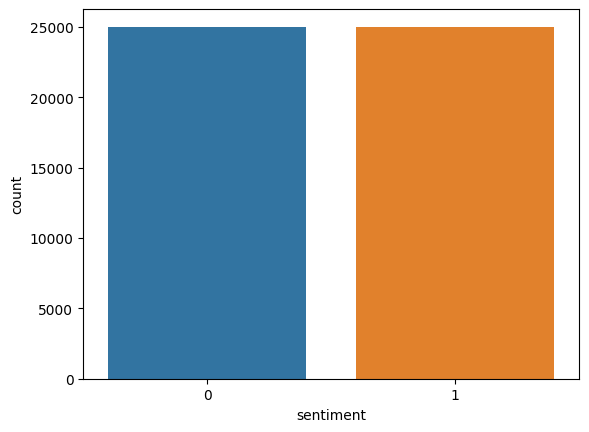

In [11]:
# Observar como está distribuido el dataset
sns.countplot(x='sentiment', data=df_reviews)
plt.show()

Se puede observar que el dataset está perfectamente balanceado

In [12]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['review'].values
text_sequences.shape

(50000,)

In [13]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

50000

In [14]:
# - Por defecto CountVectorizer elimina los signos de puntuacion y transforma
# todas las palabras a lowercase
# - max_features --> limitacion la máxima dimensión del oneHotEncoding (max vocab_size)
# - stop_words --> quitamos aquellas palabras que para el idioma no se consideran
# relevantes (como los árticulos, pronombres, preposiciones, adverbios, etc)
# - Referencia:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(text_sequences).toarray()

In [15]:
# Los datos de entrada (X) son un vector de oneHotEncoding del tamaño
# del vocabulario y de la cantidad de filas
X.shape

(50000, 2000)

In [16]:
# Tomar la columna rating y alcemacenarla en una variable "y"
# Su shape debe ser equivalente la cantidad de rows del corpus
y = df_reviews['sentiment'].values
print(y.shape)

(50000,)


In [17]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 2000
Output dim 1


In [18]:
# Utilizamos "random_split" para crear los datos de train y test
# partir del conjunto de datos_set
# Fijamos un "seed" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
test_set_size = int(data_set.len * 0.1)
train_set_size = data_set.len - valid_set_size - test_set_size
train_set, valid_test_set = torch.utils.data.random_split(data_set, [train_set_size, data_set.len - train_set_size])
valid_set, test_set = torch.utils.data.random_split(valid_test_set, [valid_set_size, len(valid_test_set) - valid_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))
print("Tamaño del conjunto de test:", len(test_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

Tamaño del conjunto de entrenamiento: 35000
Tamaño del conjunto de validacion: 10000
Tamaño del conjunto de test: 5000


### 2 - Entrenar el modelo DNN con BOW

In [19]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout1(out)
        out = self.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.relu(self.fc3(out))
        out = self.dropout2(out)
        out = self.sigmoid(self.fc4(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_size, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = nn.BCELoss()  # Para clasificación binaria

summary(model1, input_size=(1, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─Linear: 1-1                            [1, 128]                  256,128
├─ReLU: 1-2                              [1, 128]                  --
├─Dropout: 1-3                           [1, 128]                  --
├─Linear: 1-4                            [1, 64]                   8,256
├─ReLU: 1-5                              [1, 64]                   --
├─Dropout: 1-6                           [1, 64]                   --
├─Linear: 1-7                            [1, 32]                   2,080
├─ReLU: 1-8                              [1, 32]                   --
├─Dropout: 1-9                           [1, 32]                   --
├─Linear: 1-10                           [1, 1]                    33
├─Sigmoid: 1-11                          [1, 1]                    --
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
To

In [22]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=20
                )

Epoch: 1/20 - Train loss 0.288 - Train accuracy 0.886 - Valid Loss 0.319 - Valid accuracy 0.873
Epoch: 2/20 - Train loss 0.231 - Train accuracy 0.913 - Valid Loss 0.346 - Valid accuracy 0.867
Epoch: 3/20 - Train loss 0.169 - Train accuracy 0.940 - Valid Loss 0.403 - Valid accuracy 0.862
Epoch: 4/20 - Train loss 0.116 - Train accuracy 0.961 - Valid Loss 0.486 - Valid accuracy 0.858
Epoch: 5/20 - Train loss 0.089 - Train accuracy 0.971 - Valid Loss 0.593 - Valid accuracy 0.856
Epoch: 6/20 - Train loss 0.065 - Train accuracy 0.979 - Valid Loss 0.737 - Valid accuracy 0.853
Epoch: 7/20 - Train loss 0.051 - Train accuracy 0.984 - Valid Loss 0.855 - Valid accuracy 0.851
Epoch: 8/20 - Train loss 0.048 - Train accuracy 0.986 - Valid Loss 0.861 - Valid accuracy 0.854
Epoch: 9/20 - Train loss 0.043 - Train accuracy 0.986 - Valid Loss 0.918 - Valid accuracy 0.851
Epoch: 10/20 - Train loss 0.038 - Train accuracy 0.988 - Valid Loss 1.010 - Valid accuracy 0.854
Epoch: 11/20 - Train loss 0.035 - Train

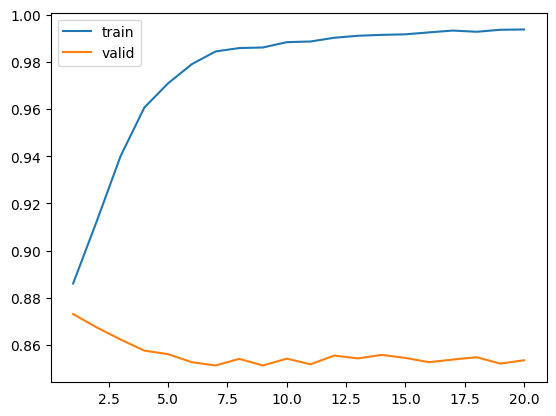

In [23]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [25]:
# Evaluar el modelo
test_data, test_target = next(iter(test_loader))
output = model1(test_data)

# Calcular el loss
test_loss = model1_criterion(output, test_target).item()
# Calcular accuracy
test_accuracy = binary_acc(output, test_target).item()

print("El modelo logro un error de {:.3f} y un accuracy de {:.3f}".format(test_loss, test_accuracy))

El modelo logro un error de 1.385 y un accuracy de 0.851


### 3 - Entrenar un modelo previamente reduciendo el vector de entrada (X)

In [ ]:
# Un vector de 2000 columnas es demasiado grande para entrenar un modelo clásico
# de deep learning (DNN)
# Se utiliza PCA para reducir la dimensionalidad
from sklearn.decomposition import PCA
X_pca = PCA(n_components=50).fit_transform(X)

In [ ]:
X_pca.shape

(50000, 50)

In [ ]:
data_set2 = Data(X_pca, y)

input_size2 = data_set2.x.shape[1]
print("input_size:", input_size2)

output_dim2 = data_set2.y.shape[1]
print("Output dim", output_dim2)

input_size: 50
Output dim 1


In [ ]:
valid_set_size2 = int(data_set2.len * 0.2)
test_set_size2 = int(data_set2.len * 0.1)
train_set_size2 = data_set2.len - valid_set_size2 - test_set_size2
train_set2, valid_test_set2 = torch.utils.data.random_split(data_set2, [train_set_size2, data_set2.len - train_set_size2])
valid_set2, test_set2 = torch.utils.data.random_split(valid_test_set2, [valid_set_size2, len(valid_test_set2) - valid_set_size2])

print("Tamaño del conjunto de entrenamiento:", len(train_set2))
print("Tamaño del conjunto de validacion:", len(valid_set2))
print("Tamaño del conjunto de test:", len(test_set2))

train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=32, shuffle=True)
valid_loader2 = torch.utils.data.DataLoader(valid_set2, batch_size=len(valid_set2), shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=len(test_set2), shuffle=True)

Tamaño del conjunto de entrenamiento: 35000
Tamaño del conjunto de validacion: 10000
Tamaño del conjunto de test: 5000


In [ ]:
# Utilizar la misma estructura de modelo del punto anterior
model2 = Model1(input_dim=input_size2, output_dim=output_dim2)
# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = nn.BCELoss()  # Para clasificación binaria

summary(model2, input_size=(1, input_size2))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─Linear: 1-1                            [1, 128]                  6,528
├─ReLU: 1-2                              [1, 128]                  --
├─Dropout: 1-3                           [1, 128]                  --
├─Linear: 1-4                            [1, 64]                   8,256
├─ReLU: 1-5                              [1, 64]                   --
├─Dropout: 1-6                           [1, 64]                   --
├─Linear: 1-7                            [1, 32]                   2,080
├─ReLU: 1-8                              [1, 32]                   --
├─Dropout: 1-9                           [1, 32]                   --
├─Linear: 1-10                           [1, 1]                    33
├─Sigmoid: 1-11                          [1, 1]                    --
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
Total 

In [ ]:
history2 = train(model2,
                train_loader2,
                valid_loader2,
                model2_optimizer,
                model2_criterion,
                epochs=20
                )

Epoch: 1/20 - Train loss 0.535 - Train accuracy 0.739 - Valid Loss 0.492 - Valid accuracy 0.768
Epoch: 2/20 - Train loss 0.495 - Train accuracy 0.768 - Valid Loss 0.489 - Valid accuracy 0.769
Epoch: 3/20 - Train loss 0.487 - Train accuracy 0.773 - Valid Loss 0.481 - Valid accuracy 0.773
Epoch: 4/20 - Train loss 0.477 - Train accuracy 0.777 - Valid Loss 0.479 - Valid accuracy 0.776
Epoch: 5/20 - Train loss 0.474 - Train accuracy 0.782 - Valid Loss 0.475 - Valid accuracy 0.776
Epoch: 6/20 - Train loss 0.469 - Train accuracy 0.781 - Valid Loss 0.477 - Valid accuracy 0.778
Epoch: 7/20 - Train loss 0.464 - Train accuracy 0.785 - Valid Loss 0.467 - Valid accuracy 0.780
Epoch: 8/20 - Train loss 0.460 - Train accuracy 0.789 - Valid Loss 0.469 - Valid accuracy 0.780
Epoch: 9/20 - Train loss 0.460 - Train accuracy 0.787 - Valid Loss 0.471 - Valid accuracy 0.779
Epoch: 10/20 - Train loss 0.455 - Train accuracy 0.792 - Valid Loss 0.475 - Valid accuracy 0.780
Epoch: 11/20 - Train loss 0.452 - Train

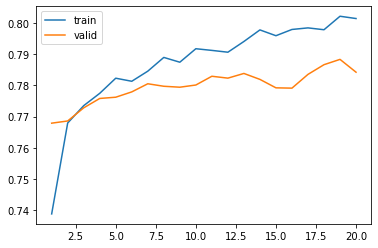

In [ ]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

In [ ]:
# Evaluar el modelo
test_data, test_target = iter(test_loader2).next()
output = model2(test_data)

# Calcular el loss
test_loss = model2_criterion(output, test_target).item()
# Calcular accuracy
test_accuracy = binary_acc(output, test_target).item()

print("El modelo logro un error de {:.3f} y un accuracy de {:.3f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.483 y un accuracy de 0.782


### 4 - Conclusión
El modelo con "bag of words" resultó ser muy fácil de armar, barato de entrenar (liviano) y obtuvo una muy buena performance.\
El modelo de dimensión reducida con PCA alcanzó menos accuracy pero realizó menos overfitting.